In [1]:

import os
import json
import librosa
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from compute_tempo import *
from extract_dance_onsets import *

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

In [5]:

fps = 60
# w_sec = 5
# h_sec = w_sec/2
# window_size = int(fps*w_sec)
# hop_size = int(fps*h_sec)

# a = 60 
# b = 140
# tempi_range = np.arange(a,b,1)
metric = "pos"
mode = "zero_uni"
# /itf-fi-ml/home/sagardu/aatoolbox_ieee/extracted_body_onsets
# main_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
# create_dir(main_dir, f"tempo_{a}_{b}")

# save_dir = f"./saved_result/tempo_{a}_{b}/"
onset_dir = f"./extracted_body_onsets_sept25/{metric}/"
f_path = "./aist_dataset/aist_annotation/keypoints2d"
aist_filelist = os.listdir(f_path)


count= 0
for idx, filename in enumerate(tqdm(aist_filelist)):
    
    file_info = filename.split("_")
    dance_genre = file_info[0] 
    situation = file_info[1] 
    camera_id = file_info[2] 
    dancer_id = file_info[3]
    music_id = file_info[4]
    choreo_id = file_info[5].strip(".pkl")
    
    test_path = os.path.join(onset_dir, "ax0", f"left_wrist_{mode}_{filename}")
    isExist = os.path.exists(test_path) 
    if not isExist:
        continue
                            
    left_hand_x  = load_pickle(os.path.join(onset_dir, "ax0", f"left_wrist_{mode}_{filename}"))
    left_hand_y  = load_pickle(os.path.join(onset_dir, "ax1", f"left_wrist_{mode}_{filename}"))
    
    right_hand_x = load_pickle(os.path.join(onset_dir, "ax0", f"right_wrist_{mode}_{filename}"))
    right_hand_y = load_pickle(os.path.join(onset_dir, "ax1", f"right_wrist_{mode}_{filename}"))
    
    left_foot_x  = load_pickle(os.path.join(onset_dir, "ax0", f"left_ankle_{mode}_{filename}"))
    left_foot_y  = load_pickle(os.path.join(onset_dir, "ax1", f"left_ankle_{mode}_{filename}"))
    
    right_foot_x = load_pickle(os.path.join(onset_dir, "ax0", f"right_ankle_{mode}_{filename}"))
    right_foot_y = load_pickle(os.path.join(onset_dir, "ax1", f"right_ankle_{mode}_{filename}"))
    
    novelty_length = left_hand_x['raw_signal'].shape[0]
    
    key = 'sensor_onsets'       #   sensor_abs_pos_filtered
    thres = 0.2     # time threshold
    
    bothhand_x = filter_dir_onsets_by_threshold((left_hand_x[key] + right_hand_x[key]), threshold_s= thres, fps=fps)
    bothhand_y = filter_dir_onsets_by_threshold((left_hand_y[key] + right_hand_y[key]), threshold_s= thres, fps=fps)

    bothfoot_x = filter_dir_onsets_by_threshold((left_foot_x[key] + right_foot_x[key]), threshold_s= thres, fps=fps)
    bothfoot_y = filter_dir_onsets_by_threshold((left_foot_y[key] + right_foot_y[key]), threshold_s= thres, fps=fps)
    
    lefthand_xy = filter_dir_onsets_by_threshold((left_hand_x[key] + left_hand_y[key]), threshold_s= thres, fps=fps)
    righthand_xy = filter_dir_onsets_by_threshold((right_hand_x[key] + right_hand_y[key]), threshold_s= thres, fps=fps)

    leftfoot_xy = filter_dir_onsets_by_threshold((left_foot_x[key] + left_foot_y[key]), threshold_s= thres, fps=fps)
    rightfoot_xy = filter_dir_onsets_by_threshold((right_foot_x[key] + right_foot_y[key]), threshold_s= thres, fps=fps)
    
    print(idx)
    if idx == 2:
        break
    

  0%|          | 2/1510 [00:00<00:05, 273.18it/s]

0
1
2


In [6]:
filename.split("_")[-2]

video_path = f"./aist_dataset/video/{filename}.mp4"
mp3_path = f"./aist_dataset/mp3/{music_id}.mp3"


y, sr = librosa.load(mp3_path, sr=22050)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, start_bpm=60, units='frames')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_times_fps = np.round(beat_times*fps).astype(int)

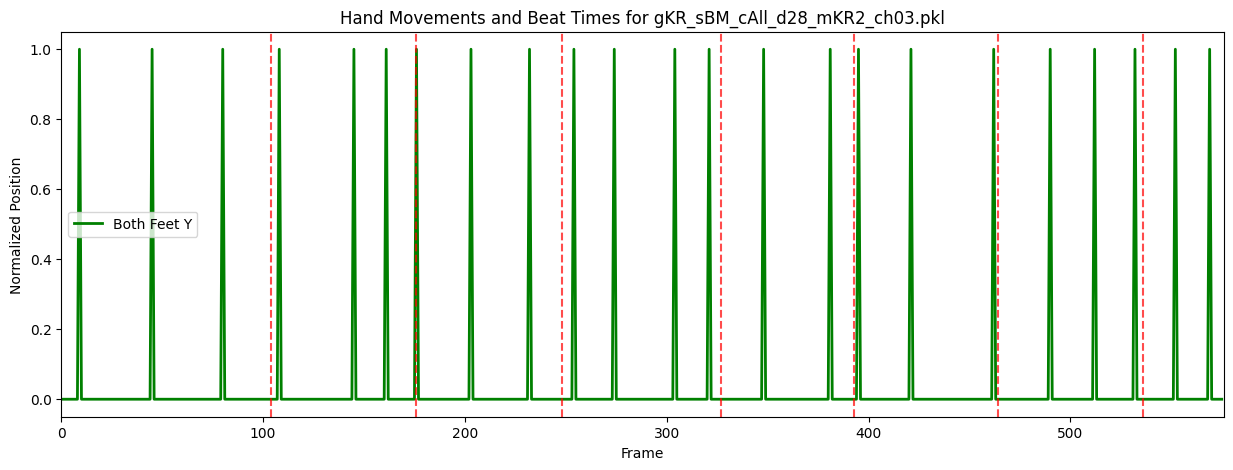

In [9]:
# plot the results
plt.figure(figsize=(15, 5))
# time = np.arange(novelty_length) / fps

# plt.plot(bothhand_y, label='Both Hands Y', color='black', linewidth=2)
plt.plot(bothfoot_y, label='Both Feet Y', color='green', linewidth=2)


for bt in beat_times_fps:       # _fps
    plt.axvline(x=bt, color='r', linestyle='--', alpha=0.7)
plt.legend()
plt.title(f"Hand Movements and Beat Times for {filename}")
plt.xlabel("Frame")
plt.ylabel("Normalized Position")
plt.xlim(0, novelty_length)
plt.show()


## For presentation

In [ ]:
aist_keypoint = "/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset/aist_annotation/keypoints2d"

/tmp/ipykernel_1232647/1139566840.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


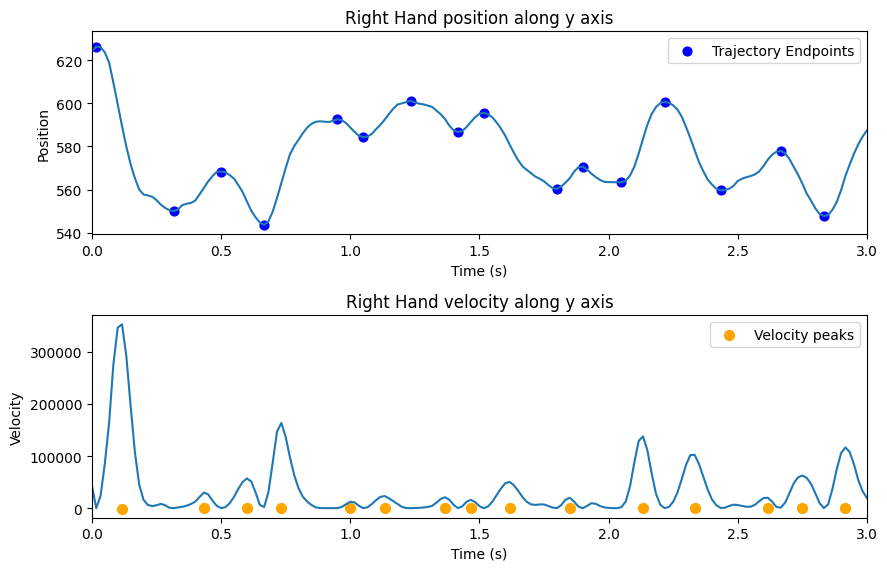

In [79]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# --- CONFIG ---
aist_keypoint_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset/aist_annotation/keypoints2d"
filename = "gMH_sBM_cAll_d23_mMH0_ch05.pkl"     # <- change to any file in the folder
marker_id = 10                                  # 9: left_wrist, 10: right_wrist, 15: left_ankle, 16: right_ankle
axis = "y"                                      # "x" or "y"
fps = 60
# smoothing
win =  nine = 9                                 # Savitzky–Golay window (odd), tweak as needed
poly = 2
# gMH_sBM_c01_d23_mMH0_ch05
# --- LOAD ---
pkl_path = os.path.join(aist_keypoint_dir, filename)
with open(pkl_path, "rb") as f:
    motion = pickle.load(f)

# motion["keypoints2d"] shape (person, frames, joints, 2); we’ll use person 0
kp = motion["keypoints2d"][0]                  # (T, J, 2)
T, J, _ = kp.shape

# --- PICK MARKER/AXIS ---
ax_idx = 0 if axis == "x" else 1
pos = kp[:, marker_id, ax_idx].astype(float)   # (T,)

# Handle all-zero frames / NaNs defensively
mask = np.isfinite(pos)
pos[~mask] = np.interp(np.flatnonzero(~mask), np.flatnonzero(mask), pos[mask])

# --- SMOOTH POSITION & VELOCITY ---
pos_s = savgol_filter(pos, window_length=nine, polyorder=poly, mode="interp")
vel = np.gradient(pos_s) * fps
vel_s = savgol_filter(vel, window_length=nine, polyorder=poly, mode="interp")

# --- DETECT ENDPOINTS (zero-velocity via extrema of position) ---
# maxima and minima of smoothed position
peaks_max, _ = find_peaks(pos_s, distance=10)
peaks_min, _ = find_peaks(-pos_s, distance=10)
endpoints = np.sort(np.concatenate([peaks_max, peaks_min]))

# --- DETECT VELOCITY PEAKS (max speed instants) ---
abs_v = np.abs(vel_s)
# set a reasonable threshold (75th percentile) to avoid noise
h = np.percentile(abs_v, 50.0)
vpeaks, _ = find_peaks(abs_v, height=h, distance=3)

# --- OPTIONAL: show full 2D skeleton for one frame (just a scatter) ---
show_skeleton = False
skel_frame = int(np.clip(T // 3, 0, T - 1))  # pick any frame to visualize
xy = kp[skel_frame]                           # (J, 2)

# --- PLOT ---
t = np.arange(T) / fps

fig = plt.figure(figsize=(10, 10), dpi=100)
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.4)

# Top: position with circles at extrema (zero-velocity)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t, pos_s, lw=1.5,) # label=f"{axis}-position (smoothed)")
ax1.scatter(t[endpoints], pos_s[endpoints], marker="o", s=40, label="Trajectory Endpoints", color="blue")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position")
ax1.set_title(f"Right Hand position along {axis} axis")
ax1.set_xlim(0, 3)
ax1.legend(loc="best")

# Bottom: velocity with triangles at peaks
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(t, vel_s**2, lw=1.5,) # label=f"{axis}-velocity (smoothed)")
ax2.scatter(t[vpeaks], vel_s[vpeaks], marker="o", s=50, label="Velocity peaks", color="orange")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity")
ax2.set_title(f"Right Hand velocity along {axis} axis")
ax2.set_xlim(0, 3)
ax2.legend(loc="best")


# fig.suptitle(
#     "Top: trajectory endpoints (zero velocity) • Bottom: velocity peaks (max speed)\n",
#     y=1.02, fontsize=11
# )
plt.tight_layout()
plt.show()


## Energy

In [2]:
mode = "zero_uni"
markerA_id = 10      # right_wrist


fps = 60
f_path = "./aist_dataset/aist_annotation/keypoints2d"
aist_filelist = os.listdir(f_path)

skipped_list = []
for idx, filename in enumerate(tqdm(aist_filelist)):
    
    file_path = os.path.join(f_path, filename)
    
    with open(file_path, 'rb') as file:
        motion_data = pickle.load(file)

    markerA_x = motion_data["keypoints2d"][0, :, markerA_id, 0]     # array (n,)
    markerA_y = motion_data["keypoints2d"][0, :, markerA_id, 1]      # array (n,)
    
    if np.all((markerA_x == 0) & (markerA_y == 0)) or np.any(np.isnan(markerA_x) | np.isnan(markerA_y)):
        skipped_list.append(filename)
        continue
    
    markerA_x = detrend_signal_array(markerA_x.reshape(-1, 1), cutoff= 1, fs=60)
    markerA_y = detrend_signal_array(markerA_y.reshape(-1, 1), cutoff= 1, fs=60)
    markerA_pos = np.concatenate((markerA_x, markerA_y), axis=1)  # size (n,2)
    
    resultant = np.sqrt(markerA_x**2 + markerA_y**2)
    # min max -1 to 1
    x_min, x_max = np.min(resultant), np.max(resultant)
    resultant_norm = (
        (resultant - x_min) / (x_max - x_min)
        if x_max != x_min  # Avoid division by zero
        else np.zeros_like(resultant)
    )
    
    for ax in range(2):
        
        # z-score
        mean_x = np.mean(markerA_pos[:, ax])
        std_x = np.std(markerA_pos[:, ax])
        
        markerA_pos_norm = (
        (markerA_pos[:, ax] - mean_x) / std_x if std_x != 0 else np.zeros_like(markerA_pos[:, ax])
        )

        markerA_ax = markerA_pos_norm.reshape(-1,1)
        
        hop_length = 6
        frame_length = 30

        sensor_abs_pos = smooth_velocity(markerA_ax, abs="no", window_length = 10, polyorder = 0) # size (n, 3)

        sensor_abs_pos[sensor_abs_pos < 0] = 0
        
        # sensor_abs_pos = np.square(np.diff(sensor_abs_pos, axis=0) )   # velocity
        
        rmse = librosa.feature.rms(y=sensor_abs_pos, frame_length=frame_length, hop_length=hop_length).flatten()
        # rmse_diff = np.zeros_like(rmse)
        # rmse_diff[1:] = np.diff(rmse)
        # energy_novelty = np.max([np.zeros_like(rmse_diff), rmse_diff], axis=0)
        
        # Use smoothed difference instead of raw diff
        rmse_smooth = np.convolve(rmse, np.ones(3)/3, mode='same')  # small moving avg
        rmse_diff = np.diff(rmse_smooth, prepend=rmse_smooth[0])
        energy_novelty = np.maximum(0, rmse_diff)
        
    print(idx)
    if idx == 8:
        break

  1%|          | 8/1510 [00:01<04:13,  5.92it/s]

0
1
2
3
5
6
7
8


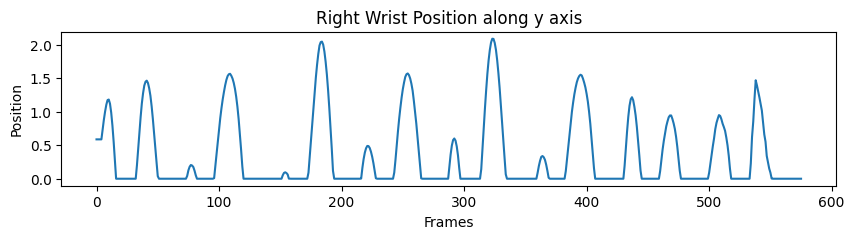

In [5]:
plt.figure(figsize=(10, 2))
plt.plot(sensor_abs_pos)
plt.xlabel('Frames')
plt.ylabel('Position')
plt.title('Right Wrist Position along y axis')
plt.show()




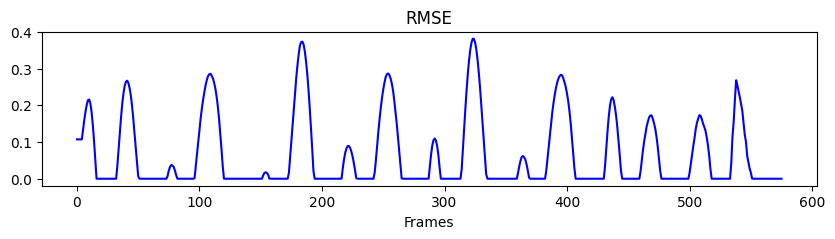

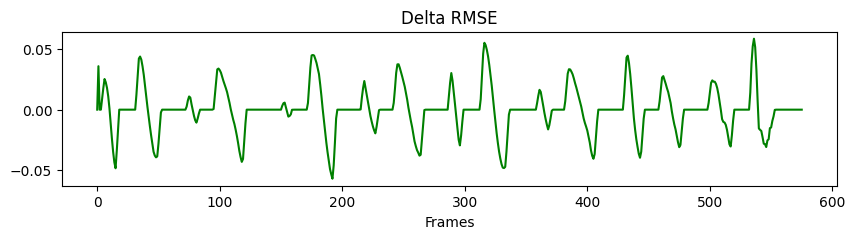

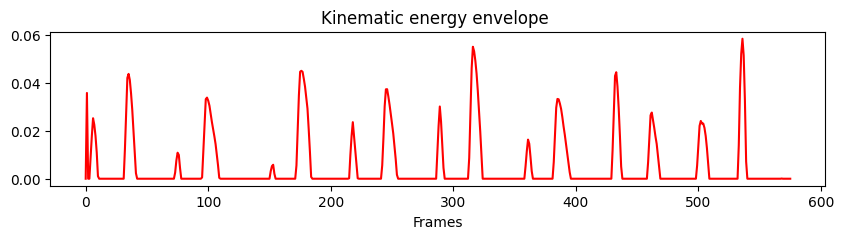

In [66]:
plt.figure(figsize=(10, 2))
plt.plot(rmse, 'b')
# plt.xlim(0, t.max())
plt.xlabel('Frames')
plt.title('RMSE')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(rmse_diff, 'g')
# plt.xlim(0, t.max())
plt.xlabel('Frames')
plt.title('Delta RMSE')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(energy_novelty, 'r')
# plt.xlim(0, t.max())
plt.xlabel('Frames')
plt.title('Kinematic energy envelope ')
plt.show()

## Novelty function

In [50]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
# import stanford_mir; stanford_mir.init()

(49613,) 22050


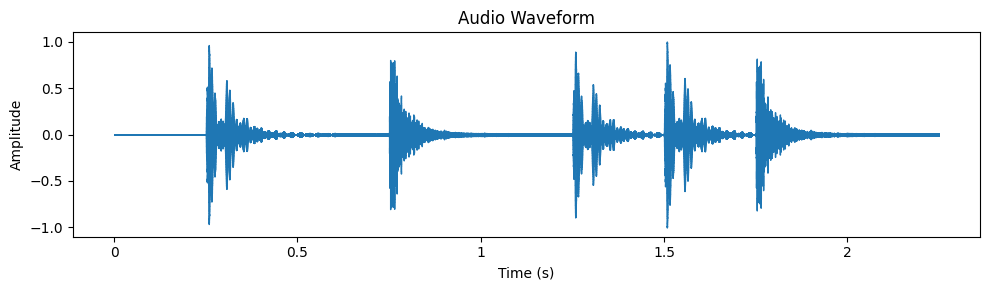

In [73]:
x, sr = librosa.load('simple_loop.wav')
print(x.shape, sr)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [63]:
hop_length = 512
frame_length = 1024
rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length).flatten()
rmse_diff = numpy.zeros_like(rmse)
rmse_diff[1:] = numpy.diff(rmse)

print(rmse.shape)
print(rmse_diff.shape)

(97,)
(97,)


In [64]:
energy_novelty = numpy.max([numpy.zeros_like(rmse_diff), rmse_diff], axis=0)
frames = numpy.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=sr)

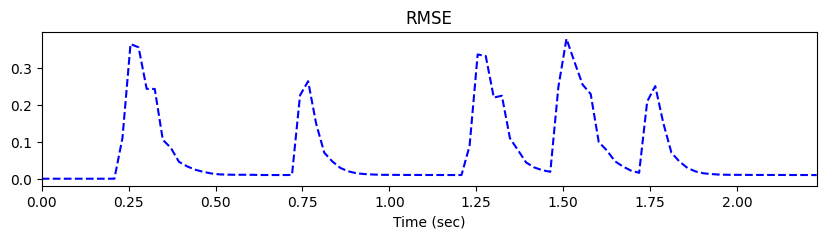

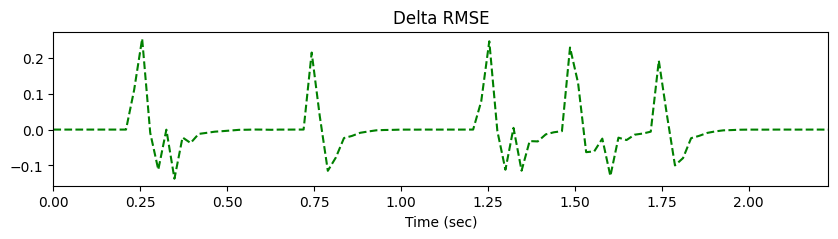

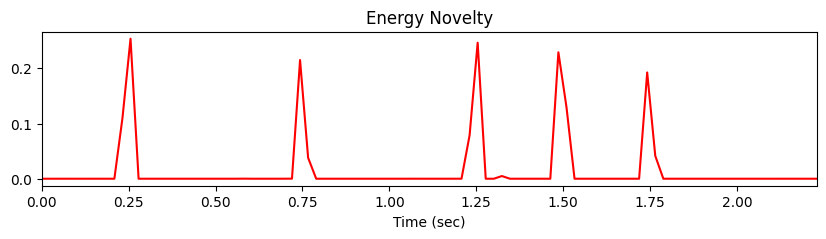

In [77]:
# plt.figure(figsize=(15, 6))
# plt.plot(t, rmse, 'b--', t, rmse_diff, 'g--^', t, energy_novelty, 'r-')
# plt.xlim(0, t.max())
# plt.xlabel('Time (sec)')
# plt.legend(('RMSE', 'delta RMSE', 'energy novelty')) 
# plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t, rmse, 'b--')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.title('RMSE')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t, rmse_diff, 'g--')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.title('Delta RMSE')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.title('Energy Novelty')
plt.show()


### Motion Signal